In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta


In [13]:
date_time = ["10-2020", "11-2020", "12-2020"]
date_time = pd.to_datetime(date_time) #turns the above list into datetime objects
data = [1, 2, 3]

date_time


DatetimeIndex(['2020-10-01', '2020-11-01', '2020-12-01'], dtype='datetime64[ns]', freq=None)

In [32]:
df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])
prices = df['Prices'].values #grabs the values in the columns and turn it into np array
dates = df['Dates'].values

prices


array([10.1 , 10.3 , 11.  , 10.9 , 10.9 , 10.9 , 10.4 ,  9.84, 10.  ,
       10.1 , 10.3 , 10.2 , 10.1 , 11.2 , 11.4 , 11.5 , 11.8 , 11.5 ,
       10.7 , 10.7 , 10.4 , 10.5 , 10.4 , 10.8 , 11.  , 11.6 , 11.6 ,
       12.1 , 11.7 , 12.  , 11.5 , 11.2 , 10.9 , 11.4 , 11.1 , 11.5 ,
       11.8 , 12.2 , 12.8 , 12.6 , 12.4 , 12.7 , 12.1 , 11.4 , 11.5 ,
       11.6 , 11.5 , 11.8 ])

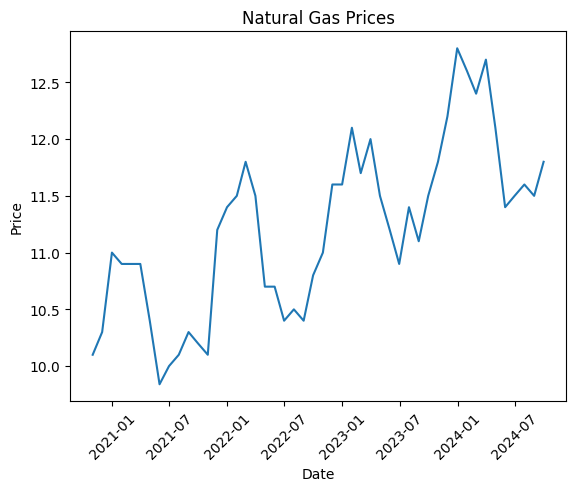

In [39]:
# plot prices against dates
fig, ax = plt.subplots()
ax.plot_date(dates, prices, '-') #used for timeseries (x-axis), alternative to plot()
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)

plt.show()

# From the plot - we can see the prices have a natural frequency of around a year, but trend upwards. 
# We can do a linear regression to get the trend, and then fit a sin function to the variation in each year.


In [70]:
# First we need the dates in terms of days from the start, to make it easier to interpolate later.
start_date = date(2020,10,31) #converts input date to datetime object
end_date = date(2024,9,30)

months = [] #create an empty list
year = start_date.year #obtain the year from the datetime object
month = start_date.month + 1

while True:
    current = date(year, month, 1) + timedelta(days=-1) # in order to format the dates to last day of month
    months.append(current) #appends the current date into the list
    if current.month == end_date.month and current.year == end_date.year:
        break #breaks the loop once the end date has been reached
    else:
        month = ((month + 1) % 12) or 12 #once the month reaches 12 (end of year), count up the year
        if month == 1:
            year += 1
        
days_from_start = [(day - start_date ).days for day in months] # number of days from the start date, in monthly frequency 

days_from_start

[0,
 30,
 61,
 92,
 120,
 151,
 181,
 212,
 242,
 273,
 304,
 334,
 365,
 395,
 426,
 457,
 485,
 516,
 546,
 577,
 607,
 638,
 669,
 699,
 730,
 760,
 791,
 822,
 850,
 881,
 911,
 942,
 972,
 1003,
 1034,
 1064,
 1095,
 1125,
 1156,
 1187,
 1216,
 1247,
 1277,
 1308,
 1338,
 1369,
 1400,
 1430]

In [55]:
# Simple regression for the trend will fit to a model y = Ax + B. The estimator for the slope is given by \hat{A} = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}, 
# and that for the intercept by \hat{B} = \bar{y} - hat{A} * \xbar

def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar))/ np.sum((x - xbar)**2)
    intercept = ybar - slope*xbar
    return slope, intercept


In [69]:
time = np.array(days_from_start) # convert the list into np array to be used as numerical time step
slope, intercept = simple_regression(time, prices) #returns a tuple (slope,intercept) which can be assigned to two variables simultaneously


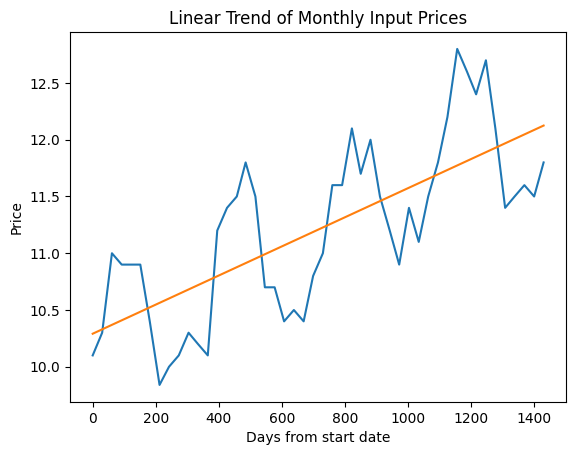

0.001282373598760221 10.29104112595228


In [67]:
# Plot linear trend
plt.plot(time, prices) #plot(x,y)
plt.plot(time, time * slope + intercept)
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.show()
print(slope, intercept)

# From this plot we see the linear trend has been captured. Now to fit the intra-year variation. 
# Given that natural gas is used more in winter, and less in summer, we can guess the frequency of the price movements to be about a year, or 12 months.
# Therefore we have a model y = Asin( kt + z ) with a known frequency.Rewriting y = Acos(z)sin(kt) + Asin(z)cos(kt),  - trig identity
# we can use bilinear regression, with no intercept, to solve for u = Acos(z), w = Asin(z)




In [90]:
sin_prices = prices - (time * slope + intercept) # difference between real values & estimated values (via linear regression)
                                                 # this effictively removes the uptrend of the sine-wave pattern
sin_time = np.sin(time * 2 * np.pi / (365)) # sin(kt) 
cos_time = np.cos(time * 2 * np.pi / (365)) # cos(kt)


In [75]:
def bilinear_regression(y, x1, x2):
    # Bilinear regression without an intercept amounts to projection onto the x-vectors
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2) # np.sum(a * b) - multiplies row-by-row of arrays a & b and take the sum of all the elements of the result
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return(slope1, slope2)



In [ ]:
# this is for visualizing and understanding sin_prices, sin_time, cos_time

plt.figure(figsize=(11,4), dpi=100) #setting up the canvas
#plt.plot(time, prices) #plot(x,y)
#plt.plot(time, time * slope + intercept)
plt.plot(time, sin_prices)
plt.plot(time, sin_time)
plt.plot(time, cos_time)

plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.show()

In [96]:
slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

print(slope1)
print(slope2)

0.6645033338185616
-0.04140626453562664


In [77]:
# We now recover the original amplitude and phase shift as A = slope1 ** 2 + slope2 ** 2, z = tan^{-1}(slope2/slope1)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)


Text(0.5, 1.0, 'Smoothed Estimate of Monthly Input Prices')

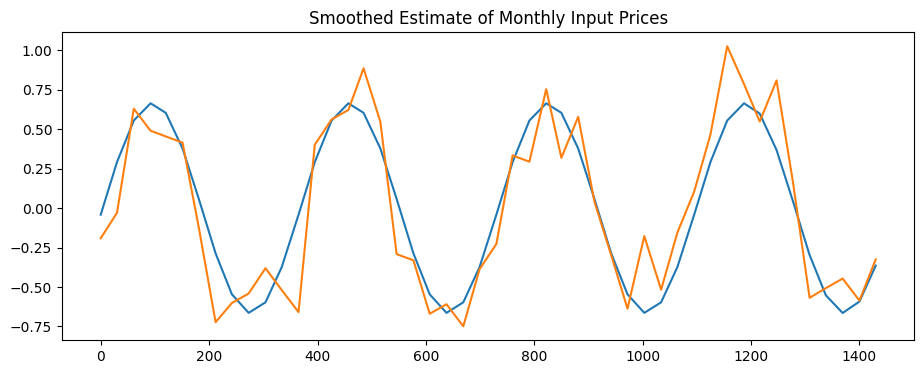

In [97]:
# Plot smoothed estimate of full dataset
plt.figure(figsize=(11,4), dpi=100)
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot(time, sin_prices)
plt.title('Smoothed Estimate of Monthly Input Prices')

################################# try to understand this portion 9/8/2023

In [80]:
# Define the interpolation/extrapolation function
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        # Exact match found in the data
        return prices[days_from_start.index(days)]
    else:
        # Interpolate/extrapolate using the sin/cos model
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept




In [81]:
# Create a range of continuous dates from start date to end date
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')


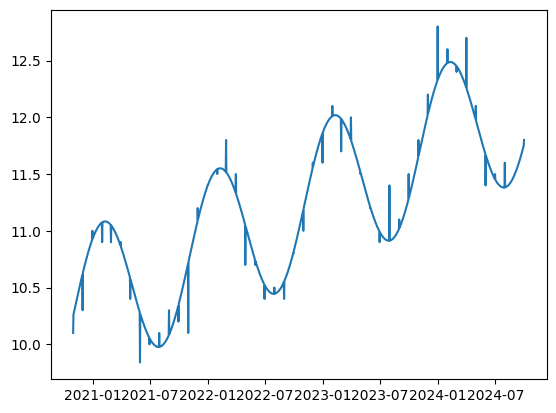

In [84]:
# Plot the smoothed estimate of the full dataset using interpolation
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')



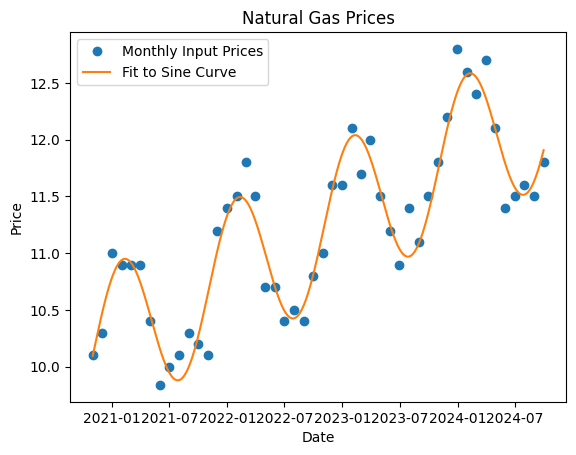

In [83]:
# Fit the monthly input prices to the sine curve
x = np.array(days_from_start)
y = np.array(prices)
fit_amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))
plt.plot(dates, y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()
